In [34]:
# Cell 1
# Load dependencies
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [35]:
# Cell 2
# Load Dataframes
# City of Fresno employee payroll:
CoF = pd.read_csv('tabula-18-Fsalary.csv',dtype={'Job_title':str,'annual_inc':'int64'})
loans = pd.read_csv('loan.csv') #Ben's Data set
data4 = pd.read_csv('loanD.csv') # Dingcheng data set
#Sheets formatted already
CoF16 = pd.read_csv('Employee-Gross-Wages2016.csv')
CoF17 = pd.read_csv('Employee-Gross-Wages2017.csv')


C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (19,55) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (19,47,55,112,123,124,125,128,129,130,133,139,140,141) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [36]:
# Cell 3
# Both loan datasets must used to form one larger dataset 
# All columns must match names to correctly train model
# No remaining NaNs after cleaning/altering
# Notes:
# CoF data will be added as columns: 'funded_amnt','installment','int_rate','dti','delinq_2yrs','loan_status'
# funded_amnt will be done in predefined as loan max 
data1 = data4[['annual_inc','funded_amnt','installment','int_rate','dti','delinq_2yrs','loan_status']]
data = loans[['annual_inc','funded_amnt','installment','int_rate','dti','delinq_2yrs','loan_status']]

# The MAIN dataframe for training:
double = pd.merge(data1,data,how='outer')

In [37]:
# Cell 4
# Change loanstatus values to number
#   0 charged off
#   1 Fully Paid
def statclean(x):
    if (x == 'Charged Off'): return 0
    elif (x == 'Fully Paid'):return 1
    elif (x.startswith('Fully', 40)): return 1 #some instances were long strings
    elif (x.startswith('Charged', 40)): return 0
# drops NaNs from df
# Because statclean() can not be executed over NaNs
double = double.dropna() 


In [38]:
# Cell 5
# Change string values to integer values (listed in statClean())
double.loan_status = double.loan_status.apply(statclean)
# Because statclean() leaves NaNs for some irrelevant info
double = double.dropna()

In [39]:
# Cell 6
# Adding missing columns to CoF:
# Initialized to Null values.
# Funded loan amount will be set to the max offered by LendingClub "40,000"

CoF['funded_amnt'] = 40000
CoF['installment'] = np.nan
CoF['int_rate'] = np.nan
CoF['dti'] = np.nan
CoF['delinq_2yrs'] = np.nan
CoF['loan_status'] = np.nan


In [40]:
# Cell 7
# What we will use to create predicted linear values
CoFX = CoF[['annual_inc','funded_amnt']]


In [41]:
# Cell 8
# Begin Logistic Regression:
# Split the data 
from sklearn.model_selection import train_test_split
X = double[['annual_inc','funded_amnt','installment','int_rate','dti','delinq_2yrs']]
y = double['loan_status']
x_trn, x_tst, y_trn, y_tst = train_test_split(X,y,test_size=.2)

# make model  
from sklearn.linear_model import LogisticRegression
logReg = LogisticRegression(max_iter=200)
logReg.fit(x_trn,y_trn)

# Stats on predictor model:   
predict = logReg.predict(x_tst)
score = logReg.score(x_tst,y_tst)
print("accuracy: ",100*score)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


accuracy:  79.99234376495359


In [42]:
# Cell 9
#Create Linear regression model,
# we train this model in order to populate the missing 
# variables needed in the employee payroll data set
# uses annual income and funded_amnt to try and predict: installment, int_rate, dti, delinq_2yrs
from sklearn.linear_model import LinearRegression
LinR= LinearRegression(fit_intercept=True,normalize=True)
X = double[['annual_inc','funded_amnt']]#['annual_inc'].values.reshape(-1,1)
y = double[['installment','int_rate','dti','delinq_2yrs']]
x_trn, x_tst,y_trn,y_tst = train_test_split(X,y,test_size=.1) 
LinR.fit(x_trn,y_trn)

# linear regressor stats
predict1= LinR.predict(x_tst)
score = LinR.score(x_tst,y_tst)
print("accuracy: ",100*score) 

accuracy:  90.91469507483097


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


In [43]:
# Cell 10
# Run Linear regressor
# Creating values for missing CoF variables:
X1Val = LinR.predict(CoFX[['annual_inc','funded_amnt']])

#Load missing dataframe values into CoF
col_names = ['installment','int_rate','dti','delinq_2yrs']
for i in range(len(X1Val)):
  for j in range(0,4):
    CoF.at[i,col_names[j]]=X1Val[i][j]

In [44]:
# Cell 11
#Run Logistic prediction model on newly filled CoF dataframe
# Log(CoF):
X1loanX = CoF[['annual_inc','funded_amnt','installment','int_rate','dti','delinq_2yrs']]
X1LoanY = logReg.predict(X1loanX)

# Write predictions into CoF
for i in range(len(X1LoanY)):
  CoF.at[i,'loan_status'] = X1LoanY[i]

Text(0.5, 0, 'Loan repayment')

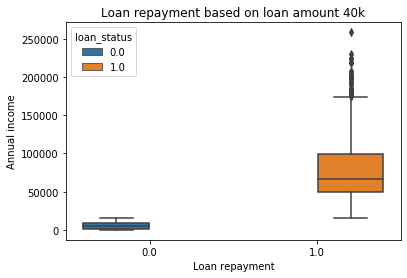

In [45]:
# Most employees able to pay loan are making over 50k a year
plt.title("Loan repayment based on loan amount 40k")
sns.boxplot(y= 'annual_inc',x='loan_status',data = CoF,hue='loan_status')
plt.ylabel("Annual income")
plt.xlabel("Loan repayment")

In [30]:
# See the numbers of defaulters vs successful repayment
CoFG = CoF.groupby('loan_status').size()
CoFG

loan_status
0.0     956
1.0    3324
dtype: int64

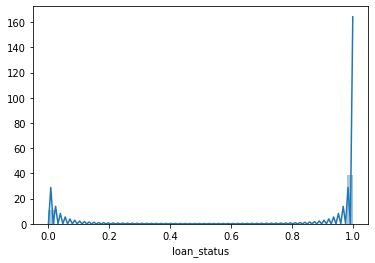

In [29]:
# The majority of employees are able to repay their loan
sns.distplot(CoF.loan_status)

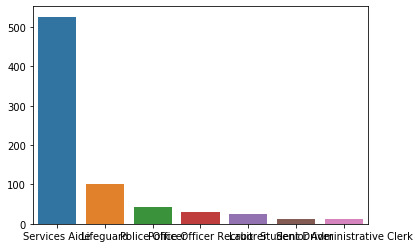

In [31]:
# The main employees not being able to repay a loan
a =CoF[CoF.loan_status == 0]
a.annual_inc.describe()
x= a.job_title.value_counts().keys()[:5]
y=a.job_title.value_counts().values[:5]
sns.barplot(x= a.job_title.value_counts().keys()[:7],y=a.job_title.value_counts().values[:7],data=a)

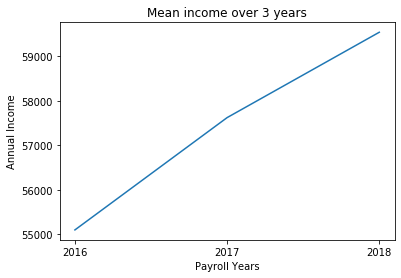

In [33]:
#Mean Income is increasing for employees
a = CoF16.annual_inc.mean()
b = CoF17.annual_inc.mean()
c = CoF.annual_inc.mean()
plt.title("Mean income over 3 years")
plt.ylabel("Annual Income")
plt.xlabel("Payroll Years")
plt.plot(['2016','2017','2018'],[a,b,c])